In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math as m
import os
from multiprocessing import Pool
import random as rd
from pathlib import Path
import sys
from scipy.integrate import simps

In [36]:
def data_reader(simulation,folder_i,file_j):
  #  print("core = " ,folder_i , "run = ", file_j)
    folder = simulation + str(folder_i) + '/'

    str_j = str(file_j)
    file_name_y = str_j + "y.csv"
    data_y = pd.read_csv('../../c++/pedsim/traj_files/'+ simulation+ "/" + folder + file_name_y, sep=",", header=0)
    lattice_y = np.array(data_y)
    #print(lattice_y.shape)
    return lattice_y


def flow_calc(lattice_y,fps,time_int,n):
    flow_list = []
    time_int_measure = time_int
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)

    ly0 = lattice_y[0:-1]
    ly1 = lattice_y[1:]
    flow_list = np.array([np.array([1  for ly0_ii,ly1_ii in zip(ly0_i, ly1_i) if (ly0_ii>0 and ly1_ii < 0)]).sum() for ly0_i,ly1_i in zip(ly0,ly1)])
    flow_plot = np.array([flow_list[k:k+n].sum() for k in t_array])
    return flow_plot

def exit_times_fetch(lattice_y,sim_time_array,fps,time_int,n,stat_state):
    flow_list = []
    exit_times = []
    time_int_measure = time_int
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)
    ly0 = np.array(lattice_y[0:-1])
    ly1 = np.array(lattice_y[1:])
    flow_list = np.array([np.array([1 for ly0_ii,ly1_ii in zip(ly0_i, ly1_i) if (np.isnan(ly0_ii) - 1 and np.isnan(ly1_ii ))]).shape[0] for ly0_i,ly1_i in zip(ly0,ly1)])
    t_i = 0
    for flow in flow_list[:sim_time_array.shape[0]]:
        if (flow > 0 and sim_time_array[t_i] > stat_state):
            exit_times.append(sim_time_array[t_i])
        t_i += 1
    exit_times = np.array(exit_times)
    exit_times_diff = exit_times[1:] - exit_times[0:-1]
    return exit_times_diff

def kaplan_meier_estimator(exit_times_diff):
    exit_times_diff_sort = np.sort(exit_times_diff)
    max_time_diff = exit_times_diff_sort.max()
    n_i = exit_times_diff_sort.shape[0]
    survival_list = []
    d_i = 0
    t_old = 0
    survival = 1
    t_inc = 0.1
    time = np.arange(0,max_time_diff,t_inc)
    survival_list = []
    for t in time:
        t_i = t_old
        while t_i < t:
            d_i += 1
            t_i += t_inc
            survival *= (1 - d_i/n_i)
        survival_list.append(survival)
        t_old = t
    return np.array(survival_list), time
    

def multi_analysis(simulation,folder_i,file_j,time_array,fps,time_int,n,stat_state,anal_type = "none"):
    lattice_y = data_reader(simulation,folder_i,file_j)
    if anal_type == "flow" or anal_type =="all":
        flow_plot = flow_calc(lattice_y,fps,time_int,n)
        return flow_plot #exit_times 
    if anal_type == "exit_diff" or anal_type =="all":
        exit_times = exit_times_fetch(lattice_y,time_array,fps,time_int,n,stat_state)
        return exit_times
    if anal_type == "survival" or anal_type =="all":
        survival = kaplan_meier_estimator(exit_times)
        return survival
    if anal_type == "none":
        print("anal_type needs specifcation which analysis to perform. choose 'flow' for flow, 'exit_diff' for difference in exit times, 'survival' for a survival plot of exit time differneces or 'all' for all mentioned")

def exit_times_flat(exit_times):
    exit_times_diff_flat = np.empty(0)
    for etd in np.array(exit_times).flatten():
        exit_times_diff_flat = np.append(exit_times_diff_flat,np.array(etd))
    return exit_times_diff_flat
def exit_times_plot(exit_times_diff_flat):
    x,bins, p = plt.hist(exit_times_diff_flat,bins = 500,density =True)
    plt.xscale('log')
    #plt.xscale('log')
    plt.show()


In [37]:
def max_frame_fetch(traj):
    return  traj['FR'].max()

def lattice_data(traj):
    max_id = traj['#ID'].max()
    max_frame = traj['FR'].max()
    print("max_frame = ", max_frame)
    data_x_new = []
    data_y_new = []
    data_id_new = []
    data_frames_new = []
    data_angle_new = []
    for id_ped in np.arange(1, max_id + 1):
        x_i = np.array(traj[traj['#ID'] == id_ped]['X'])
        x_f = np.array(traj[traj['#ID'] == id_ped]['FR'])
        y_i = np.array(traj[traj['#ID'] == id_ped]['Y'])
        angle_i = np.array(traj[traj['#ID'] == id_ped]['ANGLE'])

        if x_i.shape[0] < max_frame:
            diff = max_frame - x_i.shape[0]
            x_nan = [np.nan for i in np.arange(0, diff)]
            x_i = np.append(x_i, x_nan)
            y_i = np.append(y_i, x_nan)
            angle_i = np.append(angle_i, x_nan)
            x_f = np.append(x_f, np.arange(x_f[-1] + 1, x_f[-1] + diff + 1))
            x_id = [id_ped for i in np.arange(0, x_i.shape[0])]
        else:
            x_id = np.array(traj[traj['#ID'] == id_ped]['#ID'])  # deletes the last frame of the person with maximal frames saved to unify the length of all frames
            x_id = x_id[0:-1]
            x_i = x_i[0:-1]
            angle_i = angle_i[0:-1]

            x_f = x_f[0:-1]
            y_i = y_i[0:-1]
        data_x_new = np.append(data_x_new, x_i)
        data_id_new = np.append(data_id_new, x_id)
        data_frames_new = np.append(data_frames_new, x_f)
        data_y_new = np.append(data_y_new, y_i)
        data_angle_new = np.append(data_angle_new, angle_i)
    #print("data_x_new", data_x_new.shape)
    trajectory_dic = {'id': data_id_new, 'frame': data_frames_new, 'x': data_x_new, 'y': data_y_new, 'angle': data_angle_new}
    traj_frame = pd.DataFrame(trajectory_dic)
    x_dic = {}
    y_dic = {}
    angle_dic = {}
    x_col_old_shape = 0
    #print("check befor the loop for id 99 ", traj_frame[traj_frame['id'] == 99]['x'])
    for i in np.arange(1, max_id+1):
        x_col = np.array(traj_frame[traj_frame['id'] == i]['x'])
        y_col = np.array(traj_frame[traj_frame['id'] == i]['y'])
        angle_col = np.array(traj_frame[traj_frame['id'] == i]['angle'])
        #if x_col_old_shape != x_col.shape[0]:
            #print(x_col.shape[0],x_col_old_shape)
            #print("id = ", i," wit shape ", x_col.shape[0])
         #   print(x_col)
        x_col_old_shape = x_col.shape[0]
        
        if x_col.shape[0] != max_frame:
            print("diff = ", diff)
            diff = max_frame - x_col.shape[0]
            x_nan = [np.nan for i in np.arange(0, diff)]
            print(x_nan)
            x_col = np.append(x_col, x_nan)
            if x_col_old_shape == y_col.shape[0]:
                y_col = np.append(y_col, x_nan)
            print("in x col shape " , x_col.shape)
            
        #print("before map shapes," ,x_col.shape, y_col.shape)
        x_dic[i] = x_col
        y_dic[i] = y_col
        angle_dic[i] = angle_col
    traj_x_frame = pd.DataFrame(x_dic)
    traj_y_frame = pd.DataFrame(y_dic)
    traj_angle_frame = pd.DataFrame(angle_dic)
 
    return traj_x_frame, traj_y_frame, traj_angle_frame


In [38]:
def analyser(simulation,max_file,fps,file_number_start, max_folder,max_time, N_ped,door_width,stat_state  ,n,anal_type):
    flow_array = []

    #file_number_start = 0 #initial folder number
    time_int = int(1*fps) #intervall in which the flow is measured
    time_int_measure = time_int# intervall in which the flow is measured
    #max_folder = 16# max number of folders
    #max_file = 10 #max number of files
    #max_time = 3000 #max time of the simulation
    stat_state = 50 #time when the stationary state is reached
    threads = max_folder #how many threads does pool use
    
    folder_i = 0
    str_j = str(0) #initial file number
    folder = simulation + str(folder_i) + '/' #folder name
    file_name_y = str_j + "y.csv" # file name


    data_y = pd.read_csv(simulation, sep=",", header=0) 
    lattice_y = np.array(data_y)
    t_array = np.arange(0,lattice_y.shape[0] - time_int_measure, time_int_measure)
    for sim_t_max in max_time:
        exit_times = np.empty(0)

        sim_time_array = np.arange(0,sim_t_max,1/fps)
        #print(sim_time_array.shape)
        for file_j in np.arange(0,max_file):
            print("calculation is at ", file_j ,'/', max_file-1 )
           # print("file =", file_j)
            #print("<pool>")
            pool = Pool(processes=threads)
            g_pool = np.array([pool.apply_async(multi_analysis, args=(simulation,folder_i,file_j,sim_time_array,fps,time_int,n,stat_state,anal_type)) for folder_i in np.arange(0,max_folder)])
            flow_plot = np.array([p.get() for p in g_pool])
            pool.close()
            #print("</pool>")
            #exit_times = np.append(exit_times,flow_plot)
            flow_array.append(flow_plot)
    return flow_array, t_array

In [39]:
def densty1d(delta_x, a):
    return np.array(list(map(lambda x: 1 / (m.sqrt(m.pi) * a) * m.e ** (-x ** 2 / a ** 2), delta_x)))


def normal(lattice_x, lattice_y, x_array, y_array, a):
    x_dens = np.array(
        [lattice_x - x for x in x_array])  # calculate the distant of lattice pedestrians to the measuring lattice
    y_dens = np.array([lattice_y - y for y in y_array])

    rho_matrix_x = np.array([densty1d(delta_x, a) for delta_x in x_dens])  # density matrix is calculated
    rho_matrix_y = np.array([densty1d(delta_y, a) for delta_y in y_dens])
    rho_matrix = np.matmul(rho_matrix_x, np.transpose(rho_matrix_y))
    return rho_matrix.mean()

def b_data_name(b,dig):
    b = round(b,dig)
    str_b = ''
    for let in str(b):
        if (let in '.'):
            str_b += '_'
        else:
            str_b += let
    return str_b

In [82]:
path = "../../../files/evacuation_files/trajectories/"
sl = "/"
folder_frame = pd.read_csv("folder_list.csv")
folder_list = np.array(folder_frame['ini_folder'])
#b = np.arange(0.6,3.0,0.2)
variables = pd.read_csv("variables_list.csv")
#print(folder_list)
folder = "trajectories/"
N_runs = variables['N_runs'][0]
fps = variables['fps'][0]
b_frame = pd.read_csv("b_list.csv")
b = np.array(b_frame['b'])
N_ped = variables['N_ped'][0]
print("b/2 = ", b)
print("fps = " ,fps)
print("N_runs = ", N_runs)
print("folder_list_0", folder_list[0])
print("N_ped = ", N_ped)
print("writing files")
for i in range(N_runs):
    location = ["evac_traj_" +b_data_name(2 * bi,3) + "_"+ str(i) +".txt" for bi in b]

    for loc,run_folder in zip(location,folder_list):
        file = open(folder  + run_folder + sl +loc, 'r')
        line_count = 0
        new_file = open(folder  + run_folder+ sl + "new_" + loc ,'w')
        #print(loc)
        for line in file:
            line_count+= 1
            if line_count > 10:
                new_file.write(line)
        #os.system('rm ' + folder + loc)

        new_file.close()
print("/writing files")


b/2 =  [2.8]
fps =  16
N_runs =  1
folder_list_0 ini_lm_2/ini_5_6_lm_2
N_ped =  2
writing files
/writing files


In [73]:
"""
for bi, ini in zip(b[0:2],folder_list[0:2]):
    location = "new_evac_traj_" + b_data_name(2 * bi,3)
    density_runs = []
    max_frame = 0
    n = 2 * fps
    time_int = 5 * fps

    for i in range(2):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        print(loc)
        traj = pd.read_csv(loc, sep="\s+", header=0)
        l_x, l_y = lattice_data(traj)

        sim_time_array = np.arange(0,sim_t_max,1/fps)
        time_int = 1 * fps
        stat_state = 5 + fps
        ex_diff = exit_times_fetch(l_y,sim_time_array,fps,time_int,n,stat_state)
        #print(l_y[0:100])
"""

'\nfor bi, ini in zip(b[0:2],folder_list[0:2]):\n    location = "new_evac_traj_" + b_data_name(2 * bi,3)\n    density_runs = []\n    max_frame = 0\n    n = 2 * fps\n    time_int = 5 * fps\n\n    for i in range(2):\n        loc = folder + ini + sl + location + "_" + str(i) + ".txt"\n        print(loc)\n        traj = pd.read_csv(loc, sep="\\s+", header=0)\n        l_x, l_y = lattice_data(traj)\n\n        sim_time_array = np.arange(0,sim_t_max,1/fps)\n        time_int = 1 * fps\n        stat_state = 5 + fps\n        ex_diff = exit_times_fetch(l_y,sim_time_array,fps,time_int,n,stat_state)\n        #print(l_y[0:100])\n'

max_frame =  56
[-90.   -36.79]


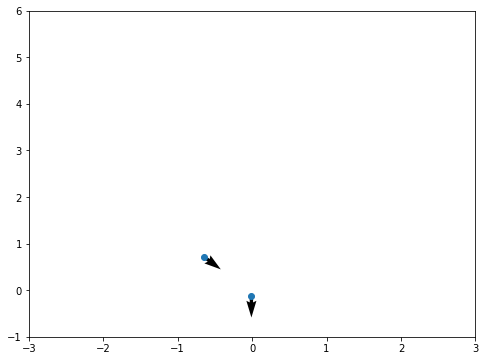

In [86]:
traj = pd.read_csv("trajectories/ini_lm_2/ini_5_6_lm_2/new_evac_traj_5_6_0.txt", sep="\s+", header=0)
l_x, l_y, angle = lattice_data(traj)
angle = np.array(angle)

fig, ax = plt.subplots(1, figsize=(8, 6))
pi = 3.1415
full_angle = 360
rad_trans = 2 * pi/full_angle
time =   fps * 2
angle_5sek = angle[time]
print(angle_5sek)
l_x_5sek = np.array(l_x)[time]
l_y_5sek = np.array(l_y)[time]
ex = [m.cos(angle_i * rad_trans) if angle_i < 0 else m.cos(abs(angle_i * rad_trans) + pi) for angle_i in angle_5sek]
ey = [m.sin(angle_i * rad_trans) if angle_i < 0 else m.sin(abs(angle_i * rad_trans) + pi) for angle_i in angle_5sek]
v_array = np.array([[ex_i,ey_i] for ex_i,ey_i in zip(ex,ey)])
plt.xlim([-3,3])
plt.ylim([-1,6])
plt.quiver(l_x_5sek,l_y_5sek, ex, ey, scale=21)
plt.scatter(l_x_5sek,l_y_5sek)
plt.show()


In [16]:
path = "../../../files/evacuation_files/trajectories/"

density_mean = []
density = []
dens_folder = "density_runs"
dens_folder_run = "density_" + str(N_ped)
os.system('mkdir ' + dens_folder)
os.system('pwd')
os.chdir(dens_folder)
os.system('mkdir ' + dens_folder_run)
os.chdir('../')
os.system('pwd')
for bi, ini in zip(b,folder_list):
    location = "new_evac_traj_" + b_data_name(2 * bi,3)
    density_runs = []
    max_frame = 0
    for i in range(N_runs):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        traj = pd.read_csv(loc, sep="\s+", header=0)
        frame = max_frame_fetch(traj)
        if frame > max_frame:
            max_frame = frame
    
    density_run = []
    density_runs_map = {}

    for i in range(N_runs):
        loc = folder + ini + sl + location + "_" + str(i) + ".txt"
        print(loc)

        traj = pd.read_csv(loc, sep="\s+", header=0)
        l_x, l_y, angle = lattice_data(traj)
        
        fwhm = 0.15
        a = fwhm * m.sqrt(2) / (2 * m.sqrt(2 * m.log(2)))
        lattice_x = np.array(l_x)
        lattice_y = np.array(l_y)
        x_array = np.linspace(-0.5,0.5,50)
        y_array = np.linspace(0.5,1.5,50)
        print("*****************<calc density>*****************")
        lat_x_no_nan = []
        lat_y_no_nan = []

        for lat_x,lat_y in zip(lattice_x,lattice_y):
            l_x_no_nan = [x  for x in lat_x if np.isnan(x) == False]
            l_y_no_nan = [y  for y in lat_y if np.isnan(y) == False]
            lat_x_no_nan.append(l_x_no_nan)
            lat_y_no_nan.append(l_y_no_nan)

        #dens_run = normal(lat_x_no_nan,lat_y_no_nan,x_array,y_array,a)
        print("    *****************<pool>*********************")
        pool = Pool()
        g_pool = np.array([pool.apply_async(normal, args=(l_x_no_nan,l_y_no_nan,x_array,y_array,a)) for l_x_no_nan, l_y_no_nan in zip(lat_x_no_nan, lat_y_no_nan)])
        density_run = [p.get() for p in g_pool]
        pool.close()
        print("    *****************</pool>********************")
        print("*****************</calc density>****************")
        
        dens_run_shape = np.array(density_run).shape[0]
        #print(dens_run_shape.shape[0],max_frame)
        print(np.array(density_run).shape)
        

        if dens_run_shape < max_frame:
            diff = int(max_frame-dens_run_shape)
            #print(diff)
            nod_list = [0 for i in np.arange(0,diff)]
            density_run = np.append(density_run,nod_list)
        #print(np.array(density_run).shape,max_frame)
        density_runs_map[str(i)] = density_run

        density_runs.append(np.array(density_run))
        #plt.plot(density_run)
    #plt.show()
    mean_runs_dens = np.array(density_runs).mean(axis=0)
    std_runs_dens = np.array(density_runs).std(axis=0)
    density.append(mean_runs_dens)
    dens_i_df = pd.DataFrame(density_runs_map)
    dens_i_df.to_csv(dens_folder + "/" + dens_folder_run + "/" +"densities_N_ped_" +str(N_ped) + "_b_" + str(bi) + ".csv")
    print("density shape = ", np.array(density).shape)
            #time = np.arange(0,59.2,0.1)
    #density_sat_state = np.array(mean_runs_dens[int(fps * 5):int(fps*10)])
    #print(density_sat_state.shape)
    #density_mean.append(density_sat_state.mean())



trajectories/ini_lm_50/ini_1_2_lm_50/new_evac_traj_1_2_0.txt
max_frame =  699
*****************<calc density>*****************
    *****************<pool>*********************
    *****************</pool>********************
*****************</calc density>****************
(699,)
trajectories/ini_lm_50/ini_1_2_lm_50/new_evac_traj_1_2_1.txt
max_frame =  744
*****************<calc density>*****************
    *****************<pool>*********************
    *****************</pool>********************
*****************</calc density>****************
(744,)
trajectories/ini_lm_50/ini_1_2_lm_50/new_evac_traj_1_2_2.txt
max_frame =  695
*****************<calc density>*****************
    *****************<pool>*********************
    *****************</pool>********************
*****************</calc density>****************
(695,)
trajectories/ini_lm_50/ini_1_2_lm_50/new_evac_traj_1_2_3.txt
max_frame =  740
*****************<calc density>*****************
    *****************<pool>***

KeyboardInterrupt: 

(930,)
(1516,)
(1516,)
(1516,)
(1516,)
(1516,)
[2.04198411 2.03890345 2.02316879 ... 0.         0.         0.        ]


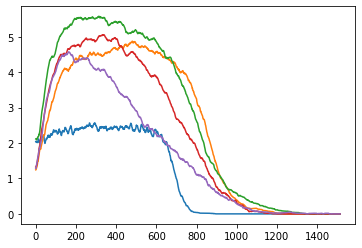

In [9]:
#print(std_runs_dens)
dens_map = {}

b = np.array(b_frame['b'])
density1 = np.array(density)
print(density1[0].shape)
shape_max = 0
for d in density1:
    #print(d.shape)
    shape = d.shape[0]
    if shape > shape_max:
        shape_max = shape
#print(shape_max)
count = 0
for d in density1:
   # print(d.shape[0])
    if d.shape[0] < shape_max:
        diff = int(shape_max-d.shape[0])
        #print("differenz = ", diff)
        nod_list = [0 for i in np.arange(0,diff)]
        d = np.append(d,nod_list)
        density1[count] = d
    count+=1
    #print(density1.shape[0])  
count = 0

t = np.arange(0,2501/25,1/25)
for d,bi in zip(density1,b):
    #print(bi)
    #bi = round(bi,3)
    print(d.shape)
    plt.plot(d)
    count += 1
    dens_map[str(bi)] = d
    

print(dens_map[str(b[0])])
dens_frame = pd.DataFrame(dens_map)
dens_frame.to_csv('dens_frame_runs_100_Nped_' + str(N_ped) + '_' + 'lm_' + 'no_source.csv')
#plt.show()

0.6
1.15
1.7
2.25
2.8


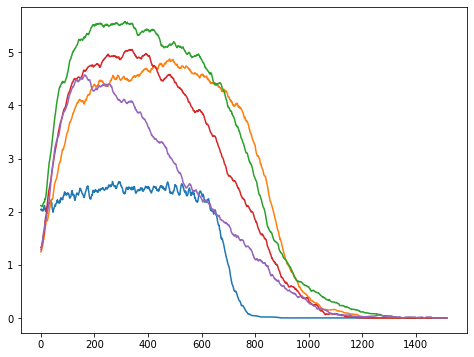

(1516,)


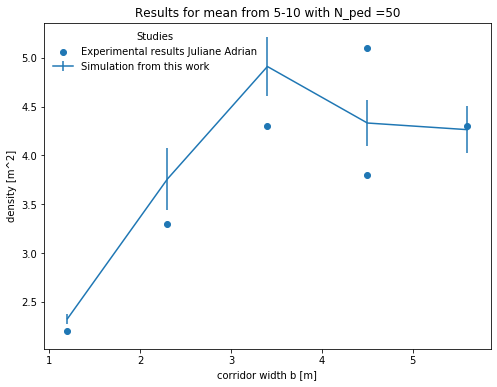

In [14]:
den = []
std = []
den2 = []

variables = pd.read_csv("variables_list.csv")
#print(folder_list)
folder = "trajectories/"
N_runs = variables['N_runs'][0]
fps = variables['fps'][0]
b_frame = pd.read_csv("b_list.csv")
b = np.array(b_frame['b'])
N_ped = variables['N_ped'][0]
b_max = b.max()
b_min = b.min()
density_pd = pd.read_csv('dens_frame_runs_100_Nped_' + str(N_ped) + '_' + 'lm_' + 'no_source.csv')
density_np = []
for key in b:
    key = round(key,3)
    print(key)
    density_np.append(density_pd[str(key)])
density_np = np.array(density_np)

fig, ax = plt.subplots(1, figsize=(8, 6))

for d,bi in zip(density_np,b):
    #print(bi)
    #bi = round(bi,3)
    plt.plot(d)
plt.show()

#plt.plot(density_pd['1.5'])
#plt.plot(density_pd['1.35'])

plt.show
print(density_np[0].shape)
#print(np.array(density)[0].mean())
fig, ax = plt.subplots(1, figsize=(8, 6))

min_t = 5
max_t = 10

array_min = min_t * fps
array_max = max_t * fps

for d in np.array(density_np):
    den.append(d[array_min: array_max].mean())
    std.append(d[array_min: array_max].std())
    #den2.append(d2[25 * 5: 25*10].mean())
den1 = []
#inv = "inv"
inv = "normal"
for d,bi in zip(den,b):
    if inv == "inv":
        den1.append(1/d)
    else:
        den1.append(d)
#b_inv = [1/bi for bi in 2 * b]

plt.errorbar( 2 * b,den1,std, label = 'Simulation from this work')
plt.xlabel('corridor width b [m]')
plt.ylabel('density [m^2]')
#plt.scatter([1.2,2.3,3.4,4.5,5.6],[2.,3.7,4.2,4.8,5], label = "Simulation results Ben Hein")
b22 = [1.2,2.3,3.4,4.5,4.5,5.6]
plt.scatter(b22,[2.2,3.3,4.3,3.8,5.1,4.3], label = "Experimental results Juliane Adrian")
plt.title("Results for mean from " + str(min_t) + "-" + str(max_t) + " with N_ped =" + str(N_ped))
ax.legend(loc="upper left", title="Studies", frameon=False)

#plt.scatter(2*b,den2)
#plt.yscale('log')
#plt.xscale('log')
plot_name = "plots/density/" + inv + "_dens_Nped_" + str(N_ped)+"_time_int_mean_" + str(min_t) + "-" + str(max_t) + "_Nruns_" + str(N_runs) + "_fps_" + str(fps) + "_brange_" + str(b_min) + "_" + str(b_max) + ".pdf" 
plt.savefig(plot_name)

plt.show()

In [11]:
t = np.arange(10,14)
n2 = [6600 * m.exp(0.231112*x)  for x in t]
krankenhaus = [497200 * 0.5 for x in t]

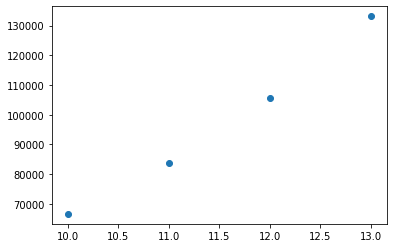

In [12]:
plt.scatter(t,n2)
#plt.plot(t,krankenhaus)

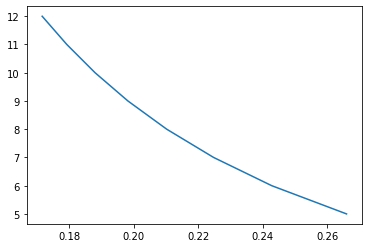

In [13]:
n = np.arange(5,13,1)
r = [m.sqrt(1/(3.1415 * ni * 0.9)) for ni in n]
plt.plot(r,n)